  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/09/82/5a5eee685095a6c1f8968db75bba8536baa8046c970be25e1ac91a843839/yfinance-0.2.33-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 66.8 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290465 sha256=cce1dd54bb819447b1fdadc7798214dca8d0d5459a50e8e957909fbf2b3bdc22
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee
Model Accuracy: 0.8534798534798534
Current Balance: 0.93 Rupees


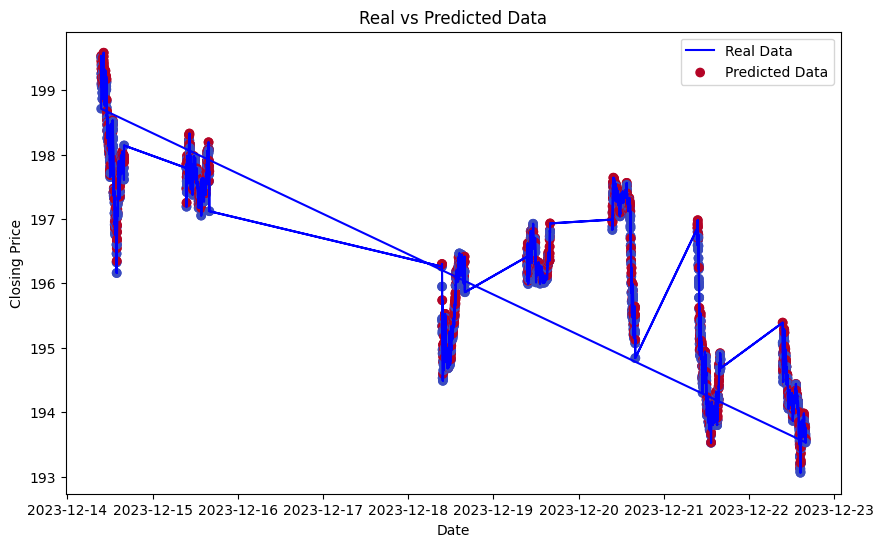

KeyboardInterrupt: 

In [1]:
!pip install yfinance pandas numpy scikit-learn matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# Function to fetch historical data
def get_historical_data(ticker, interval, period):
    stock_data = yf.download(ticker, interval=interval, period=period)
    return stock_data

# Function to fetch real-time data
def get_realtime_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period='7d', interval='1m')
    return data

# Function to preprocess data
def preprocess_data(data):
    data['returns'] = data['Close'].pct_change()
    data['target'] = np.where(data['returns'] > 0, 1, 0)
    data.dropna(inplace=True)
    return data

# Function to train a simple model
def train_model(data):
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    y = data['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    print(f'Model Accuracy: {accuracy}')
    
    return model

# Function to simulate trading
def simulate_trading(model, data, initial_balance=1):
    data['predicted'] = model.predict(data[['Open', 'High', 'Low', 'Close', 'Volume']])
    
    balance = initial_balance
    positions = 0
    
    for i in range(len(data)-1):
        if data['predicted'].iloc[i] == 1:
            # Buy
            positions += balance / data['Close'].iloc[i]
            balance = 0
        else:
            # Sell
            balance += positions * data['Close'].iloc[i]
            positions = 0
    
    # Sell remaining positions at the last data point
    balance += positions * data['Close'].iloc[-1]
    
    return balance

# Function to plot real and predicted data
def plot_data(data):
    plt.figure(figsize=(10, 6))
    
    plt.plot(data['Close'], label='Real Data', color='blue')
    plt.scatter(data.index, data['Close'], c=data['predicted'], cmap='coolwarm', marker='o', label='Predicted Data')
        
    plt.title('Real vs Predicted Data')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Main function
def main():
    ticker = 'AAPL'  # You can change this to the desired stock symbol
    
    # Fetch real-time data every 1 minute for the last 1 day
    data = get_realtime_data(ticker)
    
    # Preprocess data
    data = preprocess_data(data)
    
    model = train_model(data)
    
    while True:
        # Fetch real-time data every 1 minute
        new_data = get_realtime_data(ticker)
        
        # Update the existing data with new data
        data = pd.concat([data, new_data])
        
        # Preprocess data
        data = preprocess_data(data)
        
        # Simulate trading
        final_balance = simulate_trading(model, data)
        
        # Print current balance
        print(f'Current Balance: {final_balance:.2f} Rupees')
        
        # Plot real and predicted data
        plot_data(data)
        
        # Wait for 1 minute before fetching new data
        time.sleep(60)

if __name__ == "__main__":
    main()
